# Stage 0: SETUP

The below libraries are used for this project. For a full list of requirements and versions, please see the requirements.txt file included in the repository.

In [1]:
import json
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Stage 1: DATA ACQUISITION

## Overview
Data is acquired through the Wikimedia REST API and saved as json files. These files are included in the repository in the *data* folder; you made skip to Stage 2 and use the included files if desired.

We will request data from both the [Legacy](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) and [Pageviews](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) API.

We define base templates for the parameters. English wikipedia with monthyl granularity will always be requested, and on the pageviews api we always request agent=user to filter out crawler and bot traffic. We also request consistent dateranges for each api

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{site}/{agent}/{granularity}/{start}/{end}'
params_legacy = {"project" : "en.wikipedia.org",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2016080100"
                }

params_pageviews = {"project" : "en.wikipedia.org",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : "2021090100"
                }



We request each endpoint for each access type, except for aggregates. All data is saved in the *data* folder.
    

In [3]:
def api_call(endpoint,parameters):
    headers = {
        'User-Agent': 'https://github.com/Cain93',
        'From': 'ccase20@uw.edu'
    }
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [4]:
legacy_sites = ["desktop-site", "mobile-site"]
pageview_sites = ["desktop", "mobile-app", "mobile-web"]
file_template = "data/{apiname}_{site}_{daterange}.json"
for site in legacy_sites:
    data = api_call(endpoint_legacy, {**params_legacy, "site":site})
    fileName = file_template.format(apiname="pagecount", site=site, daterange = "200801-201607")
    with open(fileName, 'w') as outfile:
        json.dump(data, outfile)
for site in pageview_sites:
    data = api_call(endpoint_pageviews, {**params_pageviews, "site":site})
    fileName = file_template.format(apiname="pageview", site=site, daterange = "201507-202108")
    with open(fileName, 'w') as outfile:
        json.dump(data, outfile)  
    


# Stage 2: DATA PROCESSING

First we open each file and combine into a dataframe. While doing, we rename columns to make them consistent between legacy and pageview data.

In [5]:
combined_data = pd.DataFrame()
col_names = {
    "access-site": "access",
    "count": "views"
}

for filename in os.listdir("data"):
    file = open("data/" + filename, "r")
    file_data = json.loads(file.read())
    file_df = pd.DataFrame.from_records(file_data["items"]).rename(columns = col_names)
    
    combined_data = combined_data.append(file_df)

combined_data.head()

,project,access,granularity,timestamp,views,agent
0,en.wikipedia,desktop-site,monthly,2008010100,4930902570,NaN
1,en.wikipedia,desktop-site,monthly,2008020100,4818393763,NaN
2,en.wikipedia,desktop-site,monthly,2008030100,4955405809,NaN
3,en.wikipedia,desktop-site,monthly,2008040100,5159162183,NaN
4,en.wikipedia,desktop-site,monthly,2008050100,5584691092,NaN


Then we parse the timestamp into year and month, and remove unused columns.

In [6]:
combined_data["year"] = combined_data["timestamp"].apply(lambda x: x[0:4])
combined_data["month"] = combined_data["timestamp"].apply(lambda x: x[4:6])
cleaned_data = combined_data.drop(columns=["timestamp", "granularity", "project", "agent"])
cleaned_data.head()

,access,views,year,month
0,desktop-site,4930902570,2008,01
1,desktop-site,4818393763,2008,02
2,desktop-site,4955405809,2008,03
3,desktop-site,5159162183,2008,04
4,desktop-site,5584691092,2008,05


Now data is pivoted to create a new column for each type of view. After pivoting:
1. Mobile-web and mobile-app columns are combined into mobile
1. Columns are rename into more descriptive names
1. Aggregate columns for all pageview and pagecount views are created
1. Unused columns are dropped

In [7]:
# Pivot
pivot_data = cleaned_data.pivot(index = ["year", "month"], columns=["access"])
pivot_data.columns = pivot_data.columns.droplevel()

# Replace NaN with 0
pivot_data = pivot_data.fillna(0)

print(pivot_data.head())

# Combine mobil views
pivot_data["mobile"] = pivot_data["mobile-web"] + pivot_data["mobile-app"]
pivot_data = pivot_data.drop(columns = ["mobile-web", "mobile-app"])

# Rename and aggregate
pivot_data = pivot_data.rename(columns = {"desktop-site":"pagecount_desktop_views",
                                          "mobile-site": "pagecount_mobile_views",
                                          "desktop":"pageview_desktop_views",
                                          "mobile":"pageview_mobile_views",
                                          })
pivot_data["pagecount_all_views"] = pivot_data["pagecount_desktop_views"] + pivot_data["pagecount_mobile_views"]
pivot_data["pageview_all_views"] = pivot_data["pageview_desktop_views"] + pivot_data["pageview_mobile_views"]

pivot_data.head()


access      desktop  desktop-site  mobile-app  mobile-site  mobile-web
year month                                                            
2008 01         0.0  4.930903e+09         0.0          0.0         0.0
     02         0.0  4.818394e+09         0.0          0.0         0.0
     03         0.0  4.955406e+09         0.0          0.0         0.0
     04         0.0  5.159162e+09         0.0          0.0         0.0
     05         0.0  5.584691e+09         0.0          0.0         0.0


access      pageview_desktop_views  pagecount_desktop_views  \
year month                                                    
2008 01                        0.0             4.930903e+09   
     02                        0.0             4.818394e+09   
     03                        0.0             4.955406e+09   
     04                        0.0             5.159162e+09   
     05                        0.0             5.584691e+09   

access      pagecount_mobile_views  pageview_mobile_views  \
year month                                                  
2008 01                        0.0                    0.0   
     02                        0.0                    0.0   
     03                        0.0                    0.0   
     04                        0.0                    0.0   
     05                        0.0                    0.0   

access      pagecount_all_views  pageview_all_views  
year month                                           
2008 01            4.930903e+09                 0.0  
     02            4.818394e+09                 0.0  
     03            4.955406e+09                 0.0  
     04            5.159162e+09                 0.0  
     05            5.584691e+09                 0.0

The data is converted to csv and saved.

In [8]:
pivot_data.to_csv('en-wikipedia_traffic_200712-202108.csv')

# Stage 3: ANALYSIS

Some minor processing is necessary to dispaly. The year and month are combined into a datetime index, and 0's are replaced with Nan to avoid plotting them. Values re-scaled to be in billions for easier interpretation.

In [9]:
display_data = pd.read_csv('en-wikipedia_traffic_200712-202108.csv')

# Set the index as dates
display_data.index = pd.to_datetime(display_data[['year', 'month']].assign(DAY=1))
display_data.drop(columns=["year", "month"], inplace=True)

# Repplce 0 with Nan
display_data = display_data.replace(0, np.nan)

# Rescale to billions
display_data = display_data / 1000000000



With some minor formatting, we see the trend in views. In 2016 we can see the difference in the new pageview API totals compared to the legacy, attributable to the amount of web crawlers accessing pages. 

Also visible is the growth of mobile access from when it was first recorded in late 2014.

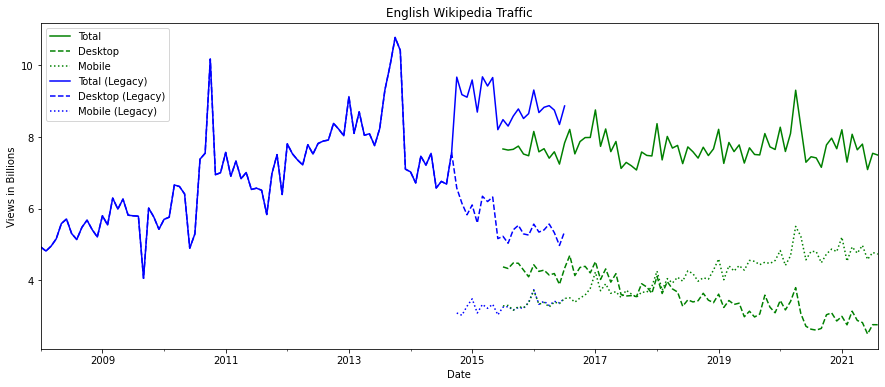

In [10]:
labels = ["Desktop", "Desktop (Legacy)", "Mobile (Legacy)", "Mobile", "Total (Legacy)", "Total"]
styles = ["g--","b--", "b:", "g:", "b", "g"]
widths = [3,3,3,3,6,6]

ax = display_data.plot(figsize=(15, 6), style=styles, title="English Wikipedia Traffic")

# Reorder legend
handles = plt.gca().get_legend_handles_labels()[0]
order = [5,0,3,4,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

# Axis titles
ax.set_xlabel("Date")
ax.set_ylabel("Views in Billions")

plt.show()

In [11]:
# Save plot
ax.get_figure().savefig("english_wikipedia_traffic.png")